In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
from fastai.text.all import *
from torch.utils.data import Dataset
from reformer_fastai.transformer import TransformerLM

In [ ]:
#hide
#skip
torch.cuda.set_device(7)

In [ ]:
#all_slow

# Synthetic task

> Explore the synthetic task explained in table 2 of the reformer paper

## Create dataset

We create items on the fly instead of all items up front. We return a tuple to make the dataloader a bit easier to inspect.

In [ ]:
class TwinSequence(Dataset):
    def __init__(self, sl=1024, len=100):
        assert sl%2 == 0
        self.sl = sl
        self.len = len
    def __getitem__(self, idx):
        seq = torch.randint(1,128,(self.sl//2,))             # w: [1-127] of len sl//2
        seq[0] = 0                                           # seq = 0w
        seq = torch.cat((seq,seq), -1)                       # seq = 0w0w
        target = torch.cat((seq[1:],torch.tensor([0])), -1)  # return offset target x:[0123], y:[1230]
        return (seq, target)                     
    def __len__(self):
        return self.len

In [ ]:
dls = DataLoaders.from_dsets(TwinSequence(10, 50), bs=6, shuffle=False, device='cuda')
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([6, 10]), torch.Size([6, 10]))

Note that the final target item is a padded 0. But that should also be predicitable from the first part of the input sequence:

In [ ]:
xb[0].tolist(), yb[0].tolist()

([0, 45, 2, 79, 104, 0, 45, 2, 79, 104],
 [45, 2, 79, 104, 0, 45, 2, 79, 104, 0])

In [ ]:
xb.shape

torch.Size([6, 10])

The number of batches in train data loader (`n_iter` in fastai lingo): The reformer paper mentions 150 k steps. One step is one iteration/batches.

In [ ]:
len(dls.train)

8

## Target masking

We have to mask the **first half** of the targets. The first part is just random integers, so it's impossible to learn anything from it. We set the tokens in the first part to a special index, -100, and later tell our lossfunction to ignore items with this value. This means that the only task the model can learn is to copy the first part of the input sequence. If we didn't mask the first part, it would be penalized for poor performance in the first part, and would try to find a compromise.

In [ ]:
class MaskTargCallback(Callback):
    def before_batch(self):
        self.y[:, :self.dls.train_ds.sl//2] = -100

We create a custom accuracy that also disregards tokens with value -100:

In [ ]:
def masked_accuracy(inp, targ, ignore=-100):
    pred = inp.argmax(dim=-1)
    mask = targ[0] != ignore
    return (pred[:,mask] == targ[:,mask]).float().mean()

In [ ]:
pred = torch.tensor([   0,   1,   2,   3,   4,1,2,3,4,55])[None,:]
targ = torch.tensor([-100,-100,-100,-100,-100,1,2,3,4,0])[None,:]
mask = targ[0] != -100
(pred[:,mask] == targ[:,mask]).float().mean()

tensor(0.8000)

And finally a callback to inspect items directly before modelling:

In [ ]:
class Inspect_items(Callback):
    def after_batch(self):
        if self.iter==0 and self.epoch==0 and self.training:
            inp = self.learn.x[0].tolist()
            targ = self.learn.y[0].tolist()
            df = pd.DataFrame((inp,targ)).T
            df.columns = ['inp', 'targ']
            print(df)

# Inspect masking

Let's check what's actually going into the model:

In [ ]:
bs, sl = 64,16
n_epochs = 1
train_sz = 500
valid_sz = 100

In [ ]:
dls = DataLoaders.from_dsets(TwinSequence(sl, train_sz), TwinSequence(sl, valid_sz), bs=bs, shuffle=False, device='cuda')

model = TransformerLM(128, 256, d_ff=256, n_layers=1, n_heads=4, max_seq_len=sl, pos_enc='fixed',
                      attn_dropout=0, ff_dropout=0, emb_dropout=0)

learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(ignore_index=-100), 
                metrics=masked_accuracy, cbs=[MaskTargCallback(), Inspect_items()])

In [ ]:
learn.fit(1, 1e-3)

epoch,train_loss,valid_loss,masked_accuracy,time
0,4.662594,4.574187,0.125000,00:02


    inp  targ
0     0  -100
1    33  -100
2    84  -100
3    88  -100
4    77  -100
5   115  -100
6   122  -100
7    21  -100
8     0    33
9    33    84
10   84    88
11   88    77
12   77   115
13  115   122
14  122    21
15   21     0


# Short sequence modelling

First we will test a short sequence with full attention to use as a baseling. We use the `TransformerLM` module.

In [ ]:
bs, sl = 64,64
n_epochs = 5
train_sz = 50_000
valid_sz = 10_000

In [ ]:
dls = DataLoaders.from_dsets(TwinSequence(sl, train_sz), TwinSequence(sl, valid_sz), bs=bs, shuffle=False, device='cuda')

model = TransformerLM(128, 256, d_ff=256, n_layers=1, n_heads=4, max_seq_len=sl, pos_enc='fixed',
                      attn_dropout=0, ff_dropout=0, emb_dropout=0)

learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(ignore_index=-100), 
                metrics=masked_accuracy, cbs=[MaskTargCallback()])

Total training steps:

In [ ]:
len(dls.train)*n_epochs

3905

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.002511886414140463)

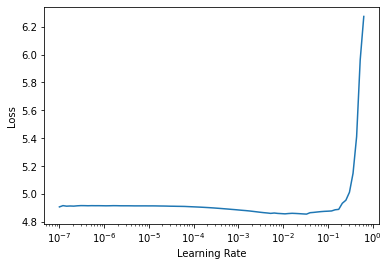

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(n_epochs, 1e-3)

epoch,train_loss,valid_loss,masked_accuracy,time
0,0.015097,0.011840,0.998072,00:20
1,0.004441,0.004059,0.999162,00:18
2,0.001301,0.000847,0.999841,00:17
3,0.000045,0.000043,1.000000,00:19
4,0.000036,0.000033,0.999997,00:17


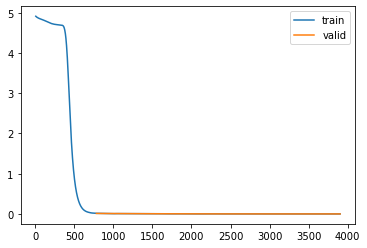

In [ ]:
learn.recorder.plot_loss()

> The model fairly quickly learns the copy task, and reaches near 0 loss within a few hundred steps